In [51]:
from tensorflow import config as tf_config
from python.models.dataset import file_loader
from python.models.model import model_getter, train_model
from python.models.unet_model import get_unet_model
from python.models.metrics import MeanIoU, Precision, Recall
from python.helpers.model import visualise_from_history, display_mask, process_mask_confidence_treshold
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import Image, display
from matplotlib import pyplot as plt
from random import SystemRandom
from PIL import ImageOps

In [2]:
gpu_amount = len(tf_config.experimental.list_physical_devices('GPU'))
print(f'GPU acceleration enabled = {gpu_amount > 0}')

GPU acceleration enabled = True


In [32]:
#: Data preperation.
image_folder = "../../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2"
mask_folder = "../../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed"
train_gen, val_gen, _, _, val_input_img_paths, val_target_img_paths = file_loader(image_folder, mask_folder)

In [4]:
#: the model metrics are calculated during compilation.
image_size, num_classes, epochs = (512, 512), 2, 25
model = model_getter(get_unet_model, image_size, num_classes)
#: Fit the model.
model_history = train_model(model, "rmsprop", "sparse_categorical_crossentropy", 
    [MeanIoU(num_classes=2), Precision(), Recall()], train_gen, val_gen, epochs)

Epoch 1/25
45/45 [==============================] - 19s 226ms/step - loss: 2.5872 - mean_iou: 0.3961 - precision: 0.2807 - recall: 0.2986 - val_loss: 1.8379 - val_mean_iou: 0.1964 - val_precision: 0.2713 - val_recall: 0.8112
Epoch 2/25
45/45 [==============================] - 9s 191ms/step - loss: 0.7949 - mean_iou: 0.4114 - precision: 0.3475 - recall: 0.2061 - val_loss: 1.0439 - val_mean_iou: 0.3608 - val_precision: 0.2744 - val_recall: 0.0063
Epoch 3/25
45/45 [==============================] - 9s 190ms/step - loss: 0.6659 - mean_iou: 0.3900 - precision: 0.2537 - recall: 0.0768 - val_loss: 0.7411 - val_mean_iou: 0.3177 - val_precision: 0.1763 - val_recall: 0.1471
Epoch 4/25
45/45 [==============================] - 9s 191ms/step - loss: 0.6135 - mean_iou: 0.3677 - precision: 0.1610 - recall: 0.0337 - val_loss: 0.6232 - val_mean_iou: 0.3595 - val_precision: 0.2090 - val_recall: 0.0015
Epoch 5/25
45/45 [==============================] - 9s 193ms/step - loss: 0.6520 - mean_iou: 0.3748 - p

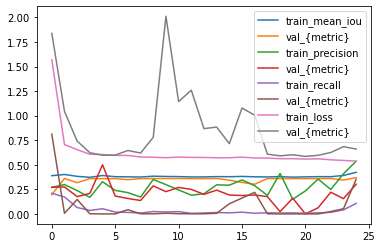

In [5]:
#: Evaluation and validation.
visualise_from_history(model_history, ["mean_iou", "precision", "recall", "loss"])

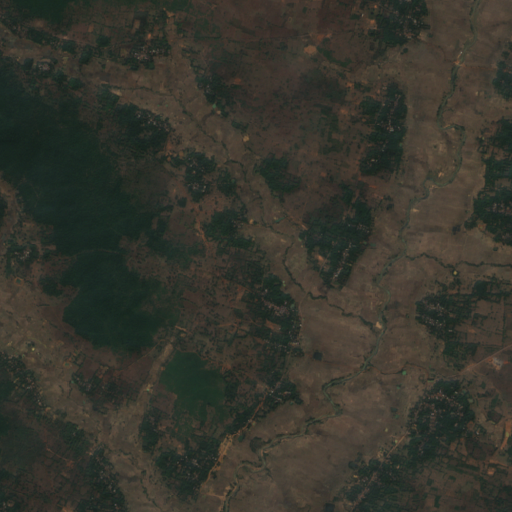

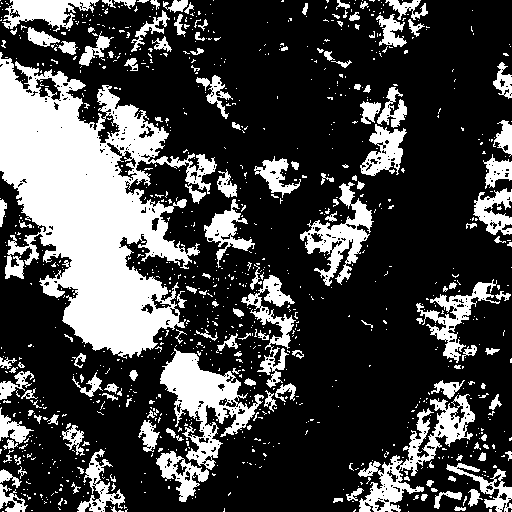

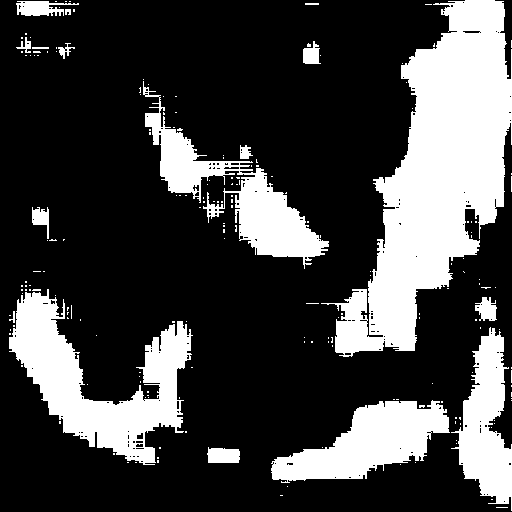

In [47]:
#: Generate predictions for all images in the validation set.
val_preds = model.predict(val_gen)

#: Take random prediction.
random_gen = SystemRandom()
i = random_gen.randrange(0, len(val_preds) - 1)

#: Display input image.
display(Image(filename=val_input_img_paths[i]))

#: Display ground-truth target mask.
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

#: Display mask predicted by our model.
display_mask(val_preds[i])

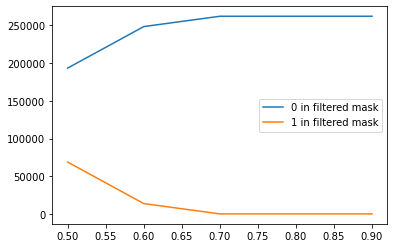

In [52]:
zeros, ones = [], []
tresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
for x in tresholds:
    data = process_mask_confidence_treshold(val_preds[i], x)
    zeros.append((data == 0).sum())
    ones.append((data == 1).sum())
    
plt.plot(tresholds, zeros, label="0 in filtered mask")
plt.plot(tresholds, ones, label="1 in filtered mask")
plt.legend()
plt.show()